In [ ]:
import cv2 as cv
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from einops import rearrange, repeat, reduce

img1 = cv.imread(cv.samples.findFile(
    "D:/my/study/code/Face_detection/data/Caltech_WebFaces/pic00001.jpg"))
img2 = cv.imread(cv.samples.findFile(
    "D:/my/study/code/Face_detection/data/Caltech_WebFaces/pic00002.jpg"))
cv.imshow("Display window", img)

k = cv.waitKey(0)  # Wait for a keystroke in the window
# img1.dtype

In [ ]:
cv.imshow("Display window", cv.cvtColor(img2, cv.COLOR_BGR2GRAY))

k = cv.waitKey(0)  # Wait for a keystroke in the window


In [ ]:
face_cascade = cv.CascadeClassifier(
    cv.data.haarcascades+'haarcascade_frontalface_default.xml')

In [ ]:
number = "00001"
img = cv.imread(cv.samples.findFile(f"D:/my/study\code\Face_detection\data\Caltech_WebFaces\pic{number}.jpg"))
# img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

for (x, y, w, h) in faces:
   img = cv.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

cv.imshow('img', img)
cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
def crop_calculate(h0, w0, coordinates):
    # unzip:
    leye_x, leye_y, reye_x, reye_y, nose_x, nose_y, mouth_x, mouth_y = coordinates
    # 鼻子作为center
    center_x = nose_x
    center_y = nose_y
    face_h = 2*(mouth_y-(leye_y+reye_y)/2)
    face_w = 2*(reye_x-leye_x)
    upper = max(0, round(center_y-(face_h/2)*1.5))
    lower = min(h0, round(center_y+face_h/2))
    left = max(0, round(center_x-face_w/2))
    right = min(w0, round(center_x+face_w/2))
    return upper, lower, left, right

In [ ]:
with open('../data/WebFaces_GroundThruth.txt') as f:
    faces = f.readlines()
all = []
for face in faces:
    all.append(tuple(face.strip().split(' ')))

In [ ]:
from tqdm import tqdm
h = []
w = []
path = 'D:/my/study/code/Face_detection/data/Caltech_WebFaces/'
for picture, *coordinates in tqdm(all):
    img = cv.imread(cv.samples.findFile(path+picture))
    upper, lower, left, right = crop_calculate(img.shape[0], img.shape[1], [float(x) for x in coordinates])
    h.append(lower-upper)
    w.append(right-left)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

# 参数依次为list,抬头,X轴标签,Y轴标签,XY轴的范围

import numpy as np
np.mean(w)
def draw_hist(myList):
    plt.hist(myList, 100)
draw_hist(w)

In [1]:
import numpy as np
samples = np.load('D:/my/study/code/Face_detection/data/feature/4_stride.npy')
labels = np.load('D:/my/study/code/Face_detection/data/labels.npy')
train_mask = np.load('D:/my/study/code/Face_detection/data/mask/train_mask.npy')
test_mask = np.load('D:/my/study/code/Face_detection/data/mask/test_mask.npy')

In [2]:
samples.shape

(17616, 11004)

In [3]:
from models import WeakClassifier, AdaBoost
model = AdaBoost(weak_classifier=WeakClassifier, num_classifiers=32)

In [ ]:
model.train(samples, labels, train_mask, test_mask)

In [5]:
import pickle
with open('D:/my/study/code/Face_detection/model/adaboost_4stride.pkl', 'wb') as f:
     pickle.dump(model, f)

In [9]:
with open('D:/my/study/code/Face_detection/data/test.txt', 'w') as f:
    for i in range(5):
        f.write(str(i))

In [1]:
import os
import numpy as np
import cv2 as cv
import json
from tqdm import tqdm
from utils import locate_face, crop_face, extract_negative_sample, compute_all_haar_features

target_size = (24, 24)

# 提取所有人脸的位置信息并存储
with open('D:/my/study/code/Face_detection/data/raw_data/WebFaces_GroundThruth.txt', 'r') as f:
    lines = f.readlines()

face_coordinates = {}
image_folder = 'D:/my/study/code/Face_detection/data/raw_data/Caltech_WebFaces'
for line in tqdm(lines, desc='Computing face coordinates'):
    parts = line.strip().split()
    image_name = parts[0]
    image_path = os.path.join(image_folder, image_name)
    img = cv.imread(image_path)
    coordinates = list(map(float, parts[1:]))
    coordinates = locate_face(img, coordinates)
    x, y, w, h = coordinates
    coordinates = (x, y, x+w, y+h)
    if image_name in face_coordinates:
        face_coordinates[image_name].append(coordinates)
    else:
        face_coordinates[image_name] = [coordinates]

Computing face coordinates: 100%|██████████| 10524/10524 [00:15<00:00, 693.32it/s]


In [2]:
stride = 12
samples = []
labels = []
# 提取正负样本
image_folder = 'D:/my/study/code/Face_detection/data/raw_data/Caltech_WebFaces'
for image_name in tqdm(os.listdir(image_folder), desc='Generating samples and features'):
    image_path = os.path.join(image_folder, image_name)
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    for face_coordinate in face_coordinates[image_name]:
        face = crop_face(img, face_coordinate, target_size)
        samples.append(compute_all_haar_features(face, stride=stride))
        labels.append(1)

    negative_sample = extract_negative_sample(img,
                                            face_coordinates[image_name],
                                            target_size)
    samples.append(compute_all_haar_features(negative_sample, stride=stride))
    labels.append(0)
samples = np.array(samples)

Generating samples and features: 100%|██████████| 7092/7092 [01:40<00:00, 70.72it/s]


In [3]:
np.save('D:/my/study/code/Face_detection/data/feature/12_stride', samples)

In [26]:
import pickle
import numpy as np
from sklearn.metrics import roc_curve
from models import AdaBoost, Logistic

feature = np.load('../data/feature/raw.npy')
labels = np.load('../data/labels.npy')
test_mask = np.load('../data/mask/test_mask.npy')
train_mask = np.load('../data/mask/train_mask.npy')
# with open('../model/logistic.pkl', 'rb') as f:
#     model = pickle.load(f)

In [27]:
from models import Logistic
model = Logistic()
model.train(feature, labels, train_mask, test_mask)

train_set: f1: 0.9391, auc: 0.9230, acc: 0.9261
test_set: f1: 0.9168, auc: 0.9052, acc: 0.9072


d:\Program Files (x86)\anaconda\envs\zhk\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
fpr, tpr, th = roc_curve(labels, y_pred[:, 1])

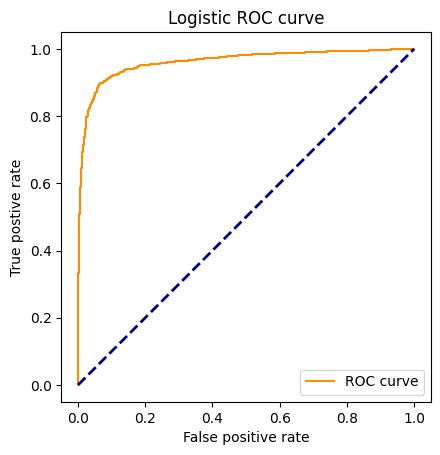

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr,color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axis("square")
plt.xlabel('False positive rate')
plt.ylabel('True postive rate')
plt.title("Logistic ROC curve")
plt.legend()
plt.show()